# News Article Classification

This notebook provides a report on work done for classifying the news articles. It covers the EDA, data preprocessing, approaches used and the evaluation metrics for each approach, API and dockerization.

## Summary

The task involves multi-label text classification, where each article can belong to multiple categories with associated confidence scores. Given a dataset containing article titles, full text, and labeled categories with probabilities, the goal is to train a model that predicts a list of relevant labels along with confidence scores for unseen articles.

Challenges:
- Imbalanced label distribution: Some categories may appear more frequently than others, affecting model performance.
- Incorrect label assigment: Some labels might be incorrectly assigned due to another agorithm that was used for labeling.
- Long text sequences: Articles may exceed common model input limits, requiring proper truncation or summarization.
- Evaluation metrics: Standard accuracy is not ideal for multi-label tasks, so metrics like F1-score, Jaccard similarity, and Hamming loss are used.

## 1. EDA
Before doing anything with data, an Exploratory Data Analysis was performed to understand the dataset structure, label distribution, and text characteristics.

In [4]:
import json
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

### Label distribution

- The dataset contains 19 categories.
- Some categories (`politics`, `economy`, `business and finance`) appear frequently, while others (`pets`, `religion and belief`) have significantly fewer samples.
- This imbalance may impact model training, requiring techniques like class weighting or oversampling/undersampling to improve performance.

In [6]:
with open('data/taxonomy_mappings.json') as f:
    label_map = json.load(f)

label_map

{'0': 'arts, culture and entertainment',
 '1': 'automotive',
 '2': 'crime, law and justice',
 '3': 'disaster and accident',
 '4': 'economy, business and finance',
 '5': 'education',
 '6': 'environment',
 '7': 'health',
 '8': 'labour',
 '9': 'lifestyle',
 '10': 'news',
 '11': 'non-standard content',
 '12': 'pets',
 '13': 'politics',
 '14': 'religion and belief',
 '15': 'science and technology',
 '16': 'society',
 '17': 'sport',
 '18': 'unrest, conflicts and war'}

In [44]:
with open('data/train_data.json') as f:
    json_raw_data = json.load(f)
raw_data = pd.DataFrame(json_raw_data)

In [45]:
all_labels = [label for labels in raw_data["labels"] for label, _ in labels]
label_counts = Counter(all_labels)

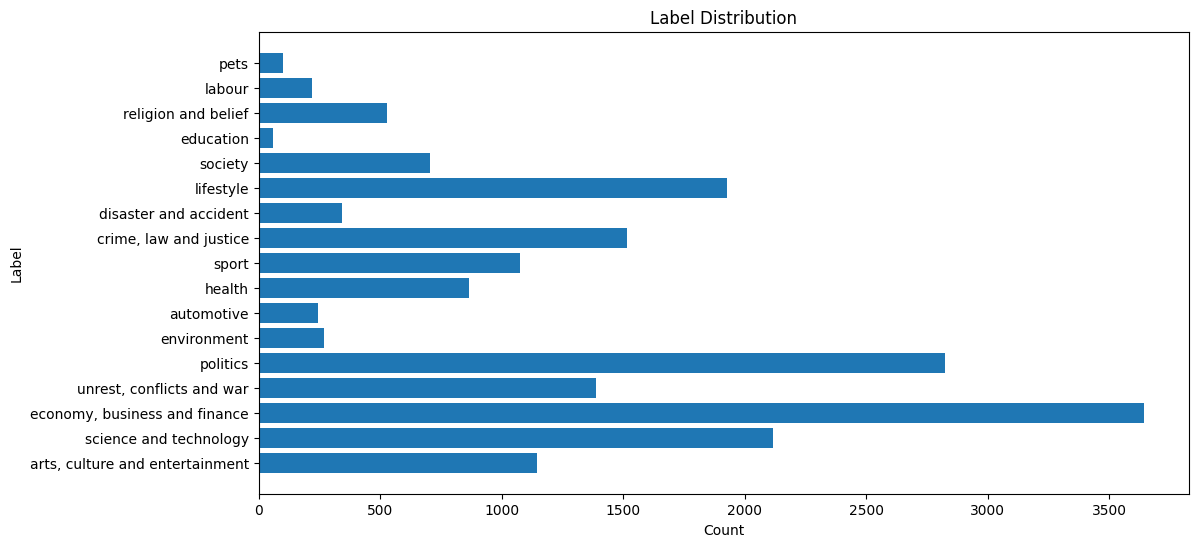

In [ ]:
plt.figure(figsize=(12, 6))
plt.barh(label_counts.keys(), label_counts.values())
plt.xlabel("Count")
plt.ylabel("Label")
plt.title("Label Distribution")
plt.show()

### Multi-label distribution
- Most articles have 2-4 labels, but some have only one, while others have more than five.
- Some labels have low confidence score (`<0.5`), not suitable for training.

In [47]:
label_counts = raw_data["labels"].apply(len)
label_counts.describe()

count    7683.000000
mean        2.469738
std         0.962707
min         0.000000
25%         2.000000
50%         2.000000
75%         3.000000
max         7.000000
Name: labels, dtype: float64

In [48]:
label_scores = pd.Series([score for sublist in raw_data['labels'] for _, score in sublist])
label_scores.describe()

count    18975.000000
mean         0.706347
std          0.202199
min          0.320000
25%          0.535100
50%          0.698100
75%          0.881400
max          1.000000
dtype: float64

### Content Analysis
- `content.title`: the title of the article. Can be seen as a summary of the article.
- `content.fullTextHtml`: the HTML content of the article body.
- `content.sections`: the content section where the article is manually assigned. It will not be available at prediction time due to a change in the editorial workflow.
- `metadata.publishedAt`: the datetime of publishing.
- `labels`: the targets of the classification task, represented as a list of lists `[label, score]`

### Text Length Analysis
- Title Length: Titles are relatively short, averaging 10-15 words.
- Full Text Length: Articles vary significantly in length, ranging from a few hundred, up to tens of thousands characters.

In [49]:
title_lengths = raw_data['content'].apply(lambda x: len(x['title']))
title_lengths.describe()

count    7683.000000
mean       81.481583
std        32.727330
min        11.000000
25%        56.000000
50%        71.000000
75%       104.000000
max       217.000000
Name: content, dtype: float64

In [50]:
text_lengths = raw_data['content'].apply(lambda x: len(x['fullTextHtml']))
text_lengths.describe()

count     7683.000000
mean      7146.950020
std       6015.670468
min         91.000000
25%       3646.500000
50%       5856.000000
75%       8597.500000
max      80027.000000
Name: content, dtype: float64

### Key Takeaways
- Label imbalance needs to be addressed to prevent bias toward frequent categories.
- Preprocessing techniques (e.g., stopword removal, lowercasing) should be considered for optimization.
- Text truncation or summarization is necessary for transformer models due to input limits.

## 2. Data Preprocessing

In the first phase of the workflow, the data was preprocessed to prepare it for model training.

Preprocessing steps:

- Feature Selection: Focused on the most relevant text fields: `content.title` (headline) and `content.fullTextHtml` (article body).
- Label Extraction: Used the provided labels with scores higher than `0.5` threshold as multi-label classification targets.
- Text Cleaning: Removed unnecessary HTML tags, special characters, extra spaces, stop words and duplicate sentences.
- Feature Extraction: Combined titles and article text into one `text` feature.
- Summarization: Ranked top-3 sentences from text in order to select most important context in shorter format.

In [ ]:
from src.preprocess import DataPreprocessor

In [2]:
data_preprocessor = DataPreprocessor()

In [2]:
data = data_preprocessor.preprocess_data(raw_data)

Index(['metadata', 'content', 'labels'], dtype='object')


In [4]:
data

,text,summary,labels,label_list
0,keanu reeves plays jedi new fanmade 'star wars...,keanu reeves plays jedi new fanmade 'star wars...,"[[arts, culture and entertainment, 0.7593], [s...","[arts, culture and entertainment, science and ..."
1,talks struggle stave climate chaos united nati...,talks struggle stave climate chaos united nati...,"[[science and technology, 0.8429], [politics, ...","[science and technology, politics, environment]"
2,housingbacked investment vehicles fueled finan...,read markets coverage markets insider business...,"[[economy, business and finance, 1.0]]","[economy, business and finance]"
3,gm's battery partnership chem major benefits c...,read photos showed tesla supercharger stations...,"[[automotive, 1.0], [economy, business and fin...","[automotive, economy, business and finance, sc..."
4,"fowler out, muhammad nami things need know new...","statement monday, presidency described mr. muh...","[[economy, business and finance, 0.7888], [pol...","[economy, business and finance, politics]"
...,...,...,...,...
7678,new advertisement ryan reynolds' aviation gin ...,watch watch talked kevin plank right stepped c...,"[[religion and belief, 0.5], [sport, 0.4997], ...",[]
7679,huawei moves overturn 'unlawful' subsidy ban c...,huawei moves overturn 'unlawful' subsidy ban c...,"[[crime, law and justice, 0.6543], [politics, ...","[crime, law and justice, politics]"
7680,threatens sanctions venezuelan lawmakers bribe...,threatens sanctions venezuelan lawmakers bribe...,"[[politics, 0.7992], [unrest, conflicts and wa...","[politics, unrest, conflicts and war]"
7681,"connect alexa roku device, control roku voice ...",related coverage everything tech connect roku ...,"[[science and technology, 1.0], [economy, busi...","[science and technology, economy, business and..."


## 3. Train/Validation/Test Dataset Split

For trying out different approaches, the dataset was split into 80% `train`, 10% `validation` and 10% `test` sets. `train` set was used for all models, `validation` only for transformer (for validation after each epoch) and `test` to calculate metrics.

The dataset contains `text` and `summary` column. `text` is used for vectorization in order to keep all useful context. `summary` is used by transformers in order to save time during training and to avoid just truncating input of the model, which is limited to 512 tokens. 

In [ ]:
from src.utils import labels_to_vector
from sklearn.model_selection import train_test_split

In [32]:
all_texts = data["text"].tolist()
all_summaries = data["summary"].tolist()
all_labels = [labels_to_vector(label_list, label_map) for label_list in data["label_list"].tolist()]

#### Split Full Text Samples

In [33]:
# Split data (80% train)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    all_texts, all_labels, test_size=0.2, random_state=42
)
# Split data (10% validation, 10% test
val_texts, test_texts, val_labels, test_labels = train_test_split(
    val_texts, val_labels, test_size=0.5, random_state=42
)

#### Split Summary Samples

In [34]:
# Split data (80% train)
train_summaries, val_summaries, train_labels, val_labels = train_test_split(
    all_summaries, all_labels, test_size=0.2, random_state=42
)

# Split data (10% validation, 10% test)
val_summaries, test_summaries, val_labels, test_labels = train_test_split(
    val_summaries, val_labels, test_size=0.5, random_state=42
)

In [38]:
train_df = pd.DataFrame({
    "text": train_texts,
    "summary": train_summaries,
    "labels": train_labels
})

validation_df = pd.DataFrame({
    "text": val_texts,
    "summary": val_summaries,
    "labels": val_labels
})

test_df = pd.DataFrame({
    "text": test_texts,
    "summary": test_summaries,
    "labels": test_labels
})

print("Train samples: ", len(train_df))
print("Validation samples: ", len(validation_df))
print("Test samples: ", len(test_df))

Train samples:  6146
Validation samples:  768
Test samples:  769


In [39]:
train_df.head()

,text,summary,labels
0,pawnshop owner connected one suspects deadly j...,"officials link ahady jersey city shooting, sai...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
1,meghan markle's favorite white sneakers sale n...,meghan markle's favorite white sneakers sale n...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
2,jailed uighur's daughter receives rights prize...,jailed uighur's daughter receives rights prize...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
3,adam neumann's golden parachute could balloon ...,adam neumann's golden parachute could balloon ...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,bangladesh closes breast milk bank islamist pr...,bangladesh closes breast milk bank islamist pr...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, ..."


In [40]:
validation_df.head()

,text,summary,labels
0,"concerned mali political delays, growing insec...","concerned mali political delays, growing insec...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
1,confirms number citizens died lamu shabaab att...,confirms number citizens died lamu shabaab att...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
2,"yes, need shacketheres musthave closet missing...",useful features like concealed chest pockets s...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
3,pompeo says iran common villain mideast protes...,pompeo says iran common villain mideast protes...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ..."
4,easily find past youtube comments edit delete ...,find comments youtube related coverage everyth...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [41]:
test_df.head()

,text,summary,labels
0,watchmen's dr. manhattan bears striking resemb...,watchmen's dr. manhattan bears striking resemb...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"insert multiple rows google sheets ways, using...",related coverage everything tech add dropdown ...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,ranked moststreamed sports events dazn 2019 on...,photo tottenham hotspur via getty images totte...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,tracing lost new york postcards streetscapes n...,tracing lost new york postcards streetscapes n...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,biden reportedly fund proposals taxing ultrari...,visit business insider's homepage stories form...,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ..."


## 4. Training `XGBoost` with text vectorization

To train the model, the updated dataframe with full text was used. For text representation, TF-IDF vectorization is leveraged.
As a classifier, XGBClassifier together with MultiOutputClassifier

MultiOutputClassifier is a scikit-learn estimator that extends the functionality of a classifier to support multi-label classification. It works by fitting multiple classifiers, one for each label, and then predicting the labels independently.

To use MultiOutputClassifier, providing a base classifier is required, such as XGBClassifier which is an implementation of the gradient boosting algorithm. XGBClassifier is known for its high performance and flexibility in handling complex datasets.

In [ ]:
from src.xgboost_model.train import XGBoostTrainer
from src.xgboost_model.predict import XGBoostPredictor

In [22]:
xgboost_trainer = XGBoostTrainer("./xgboost_model/training")
xgboost_trainer.train(train_df["text"].tolist(), train_df["labels"].tolist())

### Evaluate the model

In [37]:
from sklearn.metrics import (
    accuracy_score, precision_score, f1_score, hamming_loss, jaccard_score
)

In [25]:
xgboost_predictor = XGBoostPredictor(
                "./xgboost_model/training/trained_model.pkl",
                "./xgboost_model/training/trained_vectorizer.pkl"
)
predictions = xgboost_predictor.predict_labels(test_df["text"].tolist(), label_map)

In [31]:
predicted_labels = [[prob[0] for prob in label_vector if prob[1] > 0.5] for label_vector in predictions]
y_pred = [labels_to_vector(label_list, label_map) for label_list in predicted_labels]

y = test_df["labels"].tolist()

In [36]:
print("Accuracy: ", accuracy_score(y, y_pred))  # Exact match of all labels (not ideal for multi-label)
print("Precision: ", precision_score(y, y_pred, average='samples', zero_division=True))  # Fraction of correct positive predictions
print("F1-score (micro): ", f1_score(y, y_pred, average='micro', zero_division=True))  # Weighs all labels equally
print("F1-score (macro): ", f1_score(y, y_pred, average='macro', zero_division=True))  # Averages F1 per label (good for imbalance)
print("Hamming Loss: ", hamming_loss(y, y_pred))  # Fraction of incorrect labels (lower is better)
print("Jaccard Score (micro): ", jaccard_score(y, y_pred, average='micro'))  # Measures overlap between sets

Accuracy:  0.49934980494148246
Precision:  0.8997615951452104
F1-score (micro):  0.7907680665909951
F1-score (macro):  0.7116143177443925
Hamming Loss:  0.037848196564232425
Jaccard Score (micro):  0.6539424280350438


## 5. Training `BERT` model on summaries

To train the model, the updated dataframe with summaries of text was used (top-3 sentences). For text representation, a pre-trained BERT tokenizer was leveraged.

As a classifier, DistilBERT (a lighter version of BERT) was fine-tuned using the Hugging Face Transformers library with a multi-label classification head.

Since multi-label classification requires predicting multiple categories per input, the sigmoid activation function was applied to the output layer instead of softmax. Binary cross-entropy loss was used instead of categorical cross-entropy.

This model performed with higher metrics, but suffers from much slower training speed.

In [ ]:
from src.bert_model.train import BertTrainer
from src.bert_model.predict import BertPredictor

In [ ]:
bert_trainer = BertTrainer("./bert_model/training")
bert_trainer.train(
    train_df["summary"].tolist(),
    validation_df["summary"].tolist(),
    train_df["labels"].tolist(),
    validation_df["labels"].tolist(),
)

### Evaluate the model

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, f1_score, hamming_loss, jaccard_score
)
from src.utils import get_latest_checkpoint

In [ ]:
checkpoint_path = get_latest_checkpoint("./bert_model/training")
bert_predictor = BertPredictor(f"./bert_model/training/{checkpoint_path}")
predictions = bert_predictor.predict_labels(test_df["summary"].tolist(), label_map)

In [16]:
predicted_labels = [[prob[0] for prob in label_vector if prob[1] > 0.5] for label_vector in predictions]
y_pred = [labels_to_vector(label_list, label_map) for label_list in predicted_labels]

y = test_df["labels"].tolist()

In [17]:
print("Accuracy: ", accuracy_score(y, y_pred))  # Exact match of all labels (not ideal for multi-label)
print("Precision: ", precision_score(y, y_pred, average='samples', zero_division=True))  # Fraction of correct positive predictions
print("F1-score (micro): ", f1_score(y, y_pred, average='micro', zero_division=True))  # Weighs all labels equally
print("F1-score (macro): ", f1_score(y, y_pred, average='macro', zero_division=True))  # Averages F1 per label (good for imbalance)
print("Hamming Loss: ", hamming_loss(y, y_pred))  # Fraction of incorrect labels (lower is better)
print("Jaccard Score (micro): ", jaccard_score(y, y_pred, average='micro'))  # Measures overlap between sets

Accuracy:  0.49024707412223667
Precision:  0.8530559167750326
F1-score (micro):  0.7873668747704737
F1-score (macro):  0.7529538614769035
Hamming Loss:  0.03962767777701732
Jaccard Score (micro):  0.6493034524530588


## 6. `BERT` model, trained only on titles

In this approach, `BERT` was trained only on titles of the articles. It had superior training speed `(only 40 min training time)`, but had lower performance accuracy.
```
Accuracy: 0.4070221066319896
Precision: 0.7329865626354574
F1 Score (macro): 0.6451173447272277
Hamming Loss: 0.042105639653634
Jaccard Score: 0.605019001092512
```

## 7. `BERT` model, trained only on texts

In this approach, `BERT` was trained only on full texts of the articles. It had similar training speed to the summary-trained `BERT` `(12 hours)`, but a bit lower metrics. The downside of such approach is loss of much useful context due to model input truncation.
```
Accuracy: 0.4486345903771131
Precision: 0.8047247507585608
F1 Score (macro): 0.7271657687782525
Hamming Loss: 0.044728165231902 
Jaccard Score: 0.629607766135859
```

## 8. Zero-shot classification with `facebook/bart-large-mnli`
In this approach, the `facebook/bart-large-mnli` model was used for zero-shot classification, where no training was involved. Instead, the model directly predicts labels based on the text and predefined label descriptions. This method is useful when there is no labeled data or when you want to avoid retraining models.

However, with a labeled dataset, this approach is unnecessary since a custom model can be trained for better accuracy. Moreover, the zero-shot approach is significantly slower during inference `(30-60 sec for a single sample)` and less accurate compared to a model fine-tuned on the specific dataset. 
It does not leverage the task-specific features and context that a trained BERT model does, leading to lower performance in practical use cases.

Due to time constraints, this model was only evaluated on first 50 samples of the `test` dataset, which took `~2 hours`.
```
Accuracy: 0.0
Precision: 0.08487757701534791
F1 Score (macro): 0.14147614373930162
Hamming Loss: 0.100014624927753 
Jaccard Score: 0.121038861342338 
```

## 9. `XGBoost` classifier, trained on text embeddigs
In this approach, `XGBoost` classifier was trained on embeddings of the texts, instead of their `TF-IDF` vectors.
Embeddings and `TF-IDF` are fundamentally different in how they represent text. `TF-IDF` focuses on word frequency and importance within a specific document relative to the entire corpus, making it highly effective for tasks where the presence of specific terms is key. Embeddings, on the other hand, capture semantic meaning and relationships between words, providing a dense representation of the text but requiring more data to perform optimally.

Embeddings tend to be slower because they involve a computationally expensive process of mapping words or sentences into high-dimensional vectors, which often requires large models and inference time. For this test, `sentence-transformers/multi-qa-mpnet-base-dot-v1` was used, which took `3 hours` to embed whole dataset.

In this case, embeddings, while useful for semantic understanding, may have diluted the relevance of some specific terms, resulting in lower performance.
```
Accuracy: 0.39011703511053314
Precision: 0.671434763762462
F1 Score (macro): 0.5631246516812186
Hamming Loss: 0.045041199136859
Jaccard Score: 0.550320901502850
```

## 10. Comparison and conclusions

`BERT` model, trained on summaries, performed on par with `XGBoost` with `TF-IDF`, but suffered from long training and inference times.
In comparison, `XGBoost` with `TF-IDF` vectorization performed much faster, with sligtly lower F1-score.

| Model                     | Training time (min) | Accuracy | Precision | F1-score (macro) | Hamming Loss | Jaccard Score |
|---------------------------|---------------------|----------|-----------|------------------|--------------|---------------|
| XGBoost (`TF-IDF`)        | `10`                | `0.4993` | `0.8998`  | 0.7116           | `0.0378`     | `0.6540`      |
| BERT (`summary`)          | 600                 | 0.4902   | 0.8531    | `0.7530`         | 0.0396       | 0.6493        |
| BERT (`title`)            | 40                  | 0.4070   | 0.7330    | 0.6451           | 0.0421       | 0.6050        |
| BERT (`text`)             | 720                 | 0.4486   | 0.8047    | 0.7272           | 0.0447       | 0.6296        |
| BART (`zero-shot`)        | -                   | 0.0      | 0.0849    | 0.1415           | 0.1000       | 0.1210        |
| XGBoost (`embeddings`)    | 200                 | 0.3901   | 0.6714    | 0.5631           | 0.0450       | 0.5503        |

## 11. Next Steps

1. Balancing the Dataset:
Imbalanced label distribution could negatively affect model performance, especially for underrepresented labels.
- Use techniques like SMOTE or undersampling to balance the dataset. Alternatively, implementing class weighting.

2. Text Summarization with LLM:
Long articles might contain irrelevant information, diluting the important context necessary for multi-label classification.
- Use transformer-based summarization models (e.g., `GPT-3/4`, `T5`, or `BART`) to condense the articles into more focused summaries, making them more suitable for the model.

3. Data Augmentation:
Lack of diversity in training data could lead to overfitting.
- Use data augmentation techniques like paraphrasing, random masking of words, or back-translation to generate more training examples from the existing dataset.

4. Hyperparameter Tuning:
Model performance can be sensitive to hyperparameter choices.
- Use techniques like Grid Search or Random Search to tune hyperparameters like learning rate, batch size, and other.

5. Explore Advanced Transformer Models:
BERT might not always perform well on long text sequences.
- Explore `Longformer` which is designed to handle long documents efficiently while still capturing the relevant context.

## 12. Wrap solution in an API

To enable testing and deployment, the entire workflow, including data preprocessing, model training, and inference was integrated into a `FastAPI` application (`api.py`). This allows for quick interaction with the model via API endpoints. 

Using integrated `Swagger UI` makes it even more convenient. Accessible on `http://localhost:5000/docs`.

<img src="images/main.png" alt="main"/>

---

`/preprocess_data`

<img src="images/preprocess_data.png" alt="preprocess_data"/>

---

`/train`

<img src="images/train.png" alt="train"/>

---

`/predict`

<img src="images/predict.png" alt="predict"/>


## 13. Wrap solution in a docker container

`Dockerfile` and `.dockerignore` were created to wrap the API in a container, for deployment or testing.

The requirements are outlined in `requirements.txt`

---

**Build image**

`docker build -f Dockerfile -t text-classification .`

**Run Container**

`docker run -p 5000:5000 text-classification`